In [410]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, RidgeCV, LarsCV, Ridge, Lasso, LassoCV
from regressors import stats    
from sklearn.feature_selection import chi2

In [411]:
#Set some pandas parameters for outputs
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

In [412]:
### Define function for US map plotting ###
def plotByState(dataset, valueColName, stateColName = "State", countyColName = "FIPS Code", saveFilePath = "data/education/educationLevelsState.html"):
    #Extract only state data
    dataset = dataset[[countyColName, stateColName, valueColName]]
    datasetStates = dataset[dataset[countyColName]%1000 == 0]

    valueRange = (min(datasetStates[valueColName]), max(datasetStates[valueColName]))

    fig = px.choropleth(datasetStates, locations=datasetStates[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:"Value"},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)

def plotByCounty(dataset, valueColName, countyColName = "FIPS Code"):
    #Extract only state data
    dataset = dataset[dataset[countyColName]%1000 != 0]

    fig = px.choropleth(dataset, geojson=counties, locations=countyColName, 
    color=valueColName,color_continuous_scale="Viridis", range_color=(0, 50),scope="usa",
    labels={valueColName:"Value"},hover_name=countyColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html('data/education/educationLevelsCounty.html', auto_open=True)

In [5]:
#Load in cleaned dataset
educationDataset = pd.read_csv("data/cleaned/educationDataset.csv")

In [526]:
#Education Data
plotByState(educationDataset, "Percent of adults with less than a high school diploma, 2014-18", saveFilePath = 'data/education/educationLevelsState.html')

In [29]:
#Economic Data
plotByState(educationDataset, "Unemployment_rate_2019", saveFilePath = 'data/education/unemployment.html')
plotByState(educationDataset, "Median_Household_Income_2019", saveFilePath = 'data/education/income.html')

In [494]:
### Load in state abbreviations to create single output dataframe ###
stateAbbreviations = pd.read_csv("data/US_state_abb.csv")
statePopulations = pd.read_csv("data/us_pop.csv")
#print(statePopulations)

### Load in covid data ###
usDailyCleaned = pd.read_csv("data/cleaned/daily_df.csv")

cols = ["date","deathIncrease","state_abb"]
usDailyCleaned = usDailyCleaned[cols]
usDailyCleaned = usDailyCleaned.fillna(0)

states = usDailyCleaned.groupby("state_abb")

outputCount = pd.DataFrame()
outputCount["Total"] = states["deathIncrease"].agg(np.sum)
outputCount = outputCount.reset_index()
outputCount = outputCount.rename(columns={"state_abb":"ABBREVIATION","US State":"state"})
outputCount = outputCount.merge(stateAbbreviations, how="left", on="ABBREVIATION")
outputCount = outputCount.drop(columns=["ABBREVIATION"])
outputCount = outputCount.rename(columns={"US State":"state"})
outputCount = outputCount.merge(statePopulations,how='left',on="state").dropna()
outputCount["Output"] = (outputCount["Total"]/outputCount["Pop_2019"])*100000
outputCount = outputCount.drop(columns=["Pop_2019","Total"])

usCrossSectional = pd.read_csv("data/cleaned/us_cross_sectional.csv")

cols = ["state","positivity_rate","misperception_index"]
usCrossSectional = usCrossSectional[cols]

#print(outputCount)

### Load in misinformation data ###
stateMisinformation = pd.read_csv("data/cleaned/trend_all_time_state.csv")
stateMisperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv")

cols = ["state","covid_conspiracy","covid_hoax","plandemic"]
colsToAvg = ["covid_conspiracy","covid_hoax","plandemic"]
stateMisinformation = stateMisinformation[cols]

stateMisinformation["Misinformation Mean"] = round(stateMisinformation[cols].mean(axis=1),2)

stateMisperceptions = stateMisperceptions.rename(columns={"State":"state"})
stateMisperceptions["% belief in common misperceptions"] = stateMisperceptions["% belief in common misperceptions"].str.rstrip('%').astype('float')

#print(stateMisinformation)

### Load in mobility data ###
stateMobility = pd.read_csv("data/cleaned/US_mobility_state_cleaned.csv")

cols = ["state","non_residential_percent_change_from_baseline"]
stateMobility = stateMobility[cols]

statesMobilityGroups = stateMobility.groupby("state")

mobilityStateAvg = pd.DataFrame()
mobilityStateAvg["Mobility"] = round(statesMobilityGroups["non_residential_percent_change_from_baseline"].agg(np.mean),2)

#print(mobilityStateAvg)

#Define output array

dependentVarsDf = pd.DataFrame()
dependentVarsDf["state"] = stateMisinformation["state"]
dependentVarsDf["Misinformation Index"] = stateMisinformation["Misinformation Mean"]
dependentVarsDf = dependentVarsDf.merge(outputCount,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(mobilityStateAvg,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(stateMisperceptions, how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(usCrossSectional, how='left',on='state')
dependentVarsDf = dependentVarsDf.rename(columns={"state":"State"})

print(dependentVarsDf)

                   State  Misinformation Index  ...  positivity_rate  misperception_index
0                Alabama                 49.00  ...         0.214714            57.443833
1                 Alaska                 87.00  ...         0.035058            53.798167
2                Arizona                 54.67  ...         0.113216            56.342500
3               Arkansas                 49.33  ...         0.121433            54.048833
4             California                 53.67  ...         0.076713            62.686833
5               Colorado                 70.00  ...         0.072666            52.788333
6            Connecticut                 50.33  ...         0.043800            60.176000
7               Delaware                 35.00  ...         0.063427            58.570333
8   District of Columbia                 63.33  ...              NaN                  NaN
9                Florida                 44.67  ...         0.088200            60.304667
10        

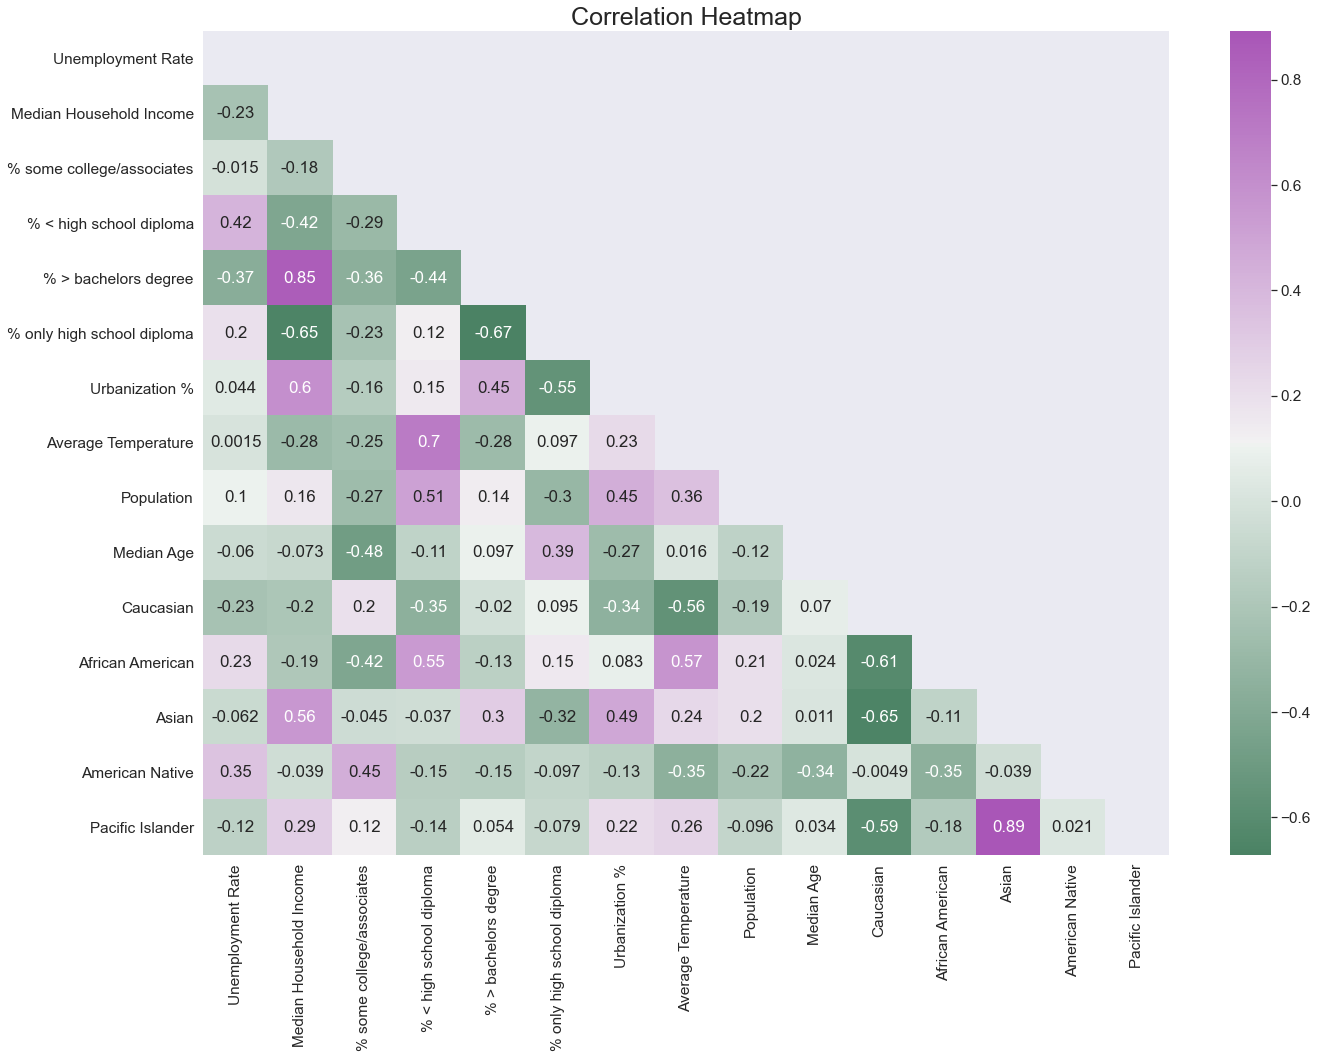

In [525]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# Examine correlations
stateEducationDataset = pd.read_csv("data/cleaned/educationStateDataset.csv")

heatmapColNames = ["Unemployment_rate_2019",
                    "Median_Household_Income_2019",
                    "% some college/associates",
                    "% < high school diploma",
                    "% > bachelors degree",
                    "% only high school diploma",
                    "Urbanization %",
                    "AverageTemperature",
                    "Pop_2019",
                    "Median Age",
                    "White",
                    "Black",
                    "Asian",
                    "American Native",
                    "Pacific Islander"]

predictorDataset = stateEducationDataset[heatmapColNames]
predictorDataset = predictorDataset.rename(columns={"Unemployment_rate_2019":"Unemployment Rate","Median_Household_Income_2019":"Median Household Income","AverageTemperature":"Average Temperature","Pop_2019":"Population","White":"Caucasian","Black":"African American"})

matrix = np.triu(np.ones_like(predictorDataset.corr(), dtype=bool))

fig, ax = plt.subplots(figsize=(20,15))  
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(predictorDataset.corr(), annot=True, mask=matrix, ax=ax, cmap=cmap)
sns.set(font_scale=1.4)

plt.title("Correlation Heatmap", fontsize=25)
plt.show()

fig.savefig("data/results/plots/correlation.png")

In [527]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

predictorDataset = stateEducationDataset[colNames]
predictorDataset.set_index("FIPS Code", inplace=True)

#Merge independent and dependent variables to create a single dataframe to run out regression
predictorDataset = predictorDataset.drop(columns=["State"])
predictorDataset = predictorDataset.rename(columns={"Area Name":"State"})
predictorDataset["Median_Household_Income_2019"] = predictorDataset["Median_Household_Income_2019"]/10000
predictorDataset["Urbanization %"] = predictorDataset["Urbanization %"]/100 
df = predictorDataset.merge(dependentVarsDf,on="State",how='left')
#print(df["Urbanization %"])

In [539]:
normalizedPredictorDataset = pd.DataFrame()

for col in predictorDataset.columns:
    if(col == "State"):
        normalizedPredictorDataset[col] = predictorDataset[col]
        continue
    
    #normalizedPredictorDataset[col] = (predictorDataset[col]-predictorDataset[col].mean())/(predictorDataset[col].std())
    normalizedPredictorDataset[col] = (predictorDataset[col]-predictorDataset[col].min())/(predictorDataset[col].max()-predictorDataset[col].min())

normdf = normalizedPredictorDataset.merge(dependentVarsDf,on="State",how='left')

In [547]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White",
        "Median_Household_Income_2019"]
X = normdf[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["misperception_index"]
y = normdf[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                      14.075728
Black                            2.317348
Asian                            3.207333
White                           13.761829
Median_Household_Income_2019     7.001562
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.493
Model:                             OLS   Adj. R-squared:                  0.436
Method:                  Least Squares   F-statistic:                     8.561
Date:                 Sun, 21 Feb 2021   Prob (F-statistic):           1.01e-05
Time:                         13:39:07   Log-Likelihood:                -116.27
No. Observations:                   50   AIC:                             244.5
Df Residuals:                       44   BIC:                             256.0
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           45.2380      6.523      6.935      0.000      32.091      58.385
Median Age                      -2.0369      2.428     -0.839      0.406      -6.929       2.856
Black                           11.5997      3.790      3.060      0.004       3.961      19.239
Asian                           12.9623      7.681      1.688      0.099      -2.517      28.442
White                            7.5803      7.085      1.070      0.290      -6.698      21.859
Median_Household_Income_2019     3.6796      1.871      1.967      0.056      -0.091       7.451
==============================================================================
Omnibus:                        1.813   Durbin-Watson:                   2.280
Prob(Omnibus):                  0.404   Jarque-Bera (JB):                1.766
Skew:                           0.397   Prob(JB):                        0.414
Kurtosis:                       2.535   Cond. No.                         49.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [541]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White",
        "Median_Household_Income_2019"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age    278.969678
Black           7.346189
Asian           5.229798
White         191.479308
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.449
Model:                             OLS   Adj. R-squared:                  0.400
Method:                  Least Squares   F-statistic:                     9.151
Date:                 Sun, 21 Feb 2021   Prob (F-statistic):           1.69e-05
Time:                         13:33:28   Log-Likelihood:                -118.37
No. Observations:                   50   AIC:                             246.7
Df Residuals:                       45   BIC:                             256.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9717     10.860      3.865      0.000      20.098      63.846
Median Age    -0.2157      0.179     -1.206      0.234      -0.576       0.145
Black         36.3249     10.270      3.537      0.001      15.640      57.010
Asian         49.5574     16.386      3.024      0.004      16.553      82.562
White         19.6002     11.152      1.758      0.086      -2.861      42.061
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                1.098
Skew:                           0.216   Prob(JB):                        0.578
Kurtosis:                       2.417   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [549]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White",
        "Median_Household_Income_2019"]
X = normdf[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = normdf[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                      14.075728
Black                            2.317348
Asian                            3.207333
White                           13.761829
Median_Household_Income_2019     7.001562
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.428
Model:                                           OLS   Adj. R-squared:                  0.363
Method:                                Least Squares   F-statistic:                     6.580
Date:                               Sun, 21 Feb 2021   Prob (F-statistic):           0.000119
Time:                                       13:39:44   Log-Likelihood:                -89.632
No. Observations:                                 50   AIC:                             191.3
Df Residuals:                                     44   BIC:                             202.7
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           18.7607      3.829      4.899      0.000      11.043      26.478
Median Age                      -3.7700      1.425     -2.645      0.011      -6.642      -0.898
Black                            1.5249      2.225      0.685      0.497      -2.959       6.009
Asian                           -3.5439      4.509     -0.786      0.436     -12.631       5.543
White                           -2.4916      4.159     -0.599      0.552     -10.873       5.890
Median_Household_Income_2019    -2.1553      1.098     -1.962      0.056      -4.369       0.058
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.181
Skew:                          -0.082   Prob(JB):                        0.913
Kurtosis:                       2.755   Cond. No.                         49.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [550]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White",
        "Median_Household_Income_2019"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                      289.133474
Black                             8.735753
Asian                             9.947776
White                           271.443388
Median_Household_Income_2019     65.827702
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.428
Model:                                           OLS   Adj. R-squared:                  0.363
Method:                                Least Squares   F-statistic:                     6.580
Date:                               Sun, 21 Feb 2021   Prob (F-statistic):           0.000119
Time:                                       13:39:53   Log-Likelihood:                -89.632
No. Observations:                                 50   AIC:                             191.3
Df Residuals:                                     44   BIC:                             202.7
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           30.8568      6.190      4.985      0.000      18.382      43.331
Median Age                      -0.2746      0.104     -2.645      0.011      -0.484      -0.065
Black                            4.1300      6.026      0.685      0.497      -8.015      16.275
Asian                           -8.5109     10.828     -0.786      0.436     -30.334      13.312
White                           -4.0240      6.717     -0.599      0.552     -17.560       9.513
Median_Household_Income_2019    -0.5294      0.270     -1.962      0.056      -1.073       0.014
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.181
Skew:                          -0.082   Prob(JB):                        0.913
Kurtosis:                       2.755   Cond. No.                     2.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [542]:
xcols = [
        "Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = normdf[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = normdf[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                    21.803313
Urbanization %                10.745958
% > bachelors degree          13.603153
% < high school diploma        4.253047
% only high school diploma     9.542684
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.502
Model:                                           OLS   Adj. R-squared:                  0.446
Method:                                Least Squares   F-statistic:                     8.881
Date:                               Sun, 21 Feb 2021   Prob (F-statistic):           6.90e-06
Time:                                       13:34:46   Log-Likelihood:                -86.147
No. Observations:                                 50   AIC:                             184.3
Df Residuals:                                     44   BIC:                             195.8
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         15.6989      1.408     11.152      0.000      12.862      18.536
Median Age                    -3.8078      1.645     -2.315      0.025      -7.122      -0.493
Urbanization %                -2.2237      1.070     -2.078      0.044      -4.381      -0.067
% > bachelors degree           0.0027      1.761      0.002      0.999      -3.547       3.552
% < high school diploma        4.3312      0.960      4.514      0.000       2.397       6.265
% only high school diploma    -0.0397      1.891     -0.021      0.983      -3.852       3.772
==============================================================================
Omnibus:                        1.919   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.279
Skew:                          -0.382   Prob(JB):                        0.528
Kurtosis:                       3.172   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [516]:
xcols = [
        "Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                    421.728513
Urbanization %                 44.003164
% > bachelors degree          119.949468
% < high school diploma        23.349039
% only high school diploma    142.616335
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.502
Model:                                           OLS   Adj. R-squared:                  0.446
Method:                                Least Squares   F-statistic:                     8.881
Date:                               Sat, 20 Feb 2021   Prob (F-statistic):           6.90e-06
Time:                                       21:32:44   Log-Likelihood:                -86.147
No. Observations:                                 50   AIC:                             184.3
Df Residuals:                                     44   BIC:                             195.8
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         22.8016      4.633      4.922      0.000      13.465      32.138
Median Age                    -0.2773      0.120     -2.315      0.025      -0.519      -0.036
Urbanization %                -3.9498      1.901     -2.078      0.044      -7.781      -0.119
% > bachelors degree           0.0001      0.078      0.002      0.999      -0.157       0.157
% < high school diploma        0.4205      0.093      4.514      0.000       0.233       0.608
% only high school diploma    -0.0020      0.095     -0.021      0.983      -0.194       0.190
==============================================================================
Omnibus:                        1.919   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.279
Skew:                          -0.382   Prob(JB):                        0.528
Kurtosis:                       3.172   Cond. No.                     1.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [543]:
xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = normdf[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["misperception_index"]
y = normdf[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                    21.803313
Urbanization %                10.745958
% > bachelors degree          13.603153
% < high school diploma        4.253047
% only high school diploma     9.542684
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.547
Model:                             OLS   Adj. R-squared:                  0.496
Method:                  Least Squares   F-statistic:                     10.64
Date:                 Sun, 21 Feb 2021   Prob (F-statistic):           9.64e-07
Time:                         13:35:33   Log-Likelihood:                -113.44
No. Observations:                   50   AIC:                             238.9
Df Residuals:                       44   BIC:                             250.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         47.7990      2.430     19.672      0.000      42.902      52.696
Median Age                     1.0737      2.839      0.378      0.707      -4.647       6.795
Urbanization %                 3.3105      1.847      1.792      0.080      -0.412       7.034
% > bachelors degree           6.4662      3.040      2.127      0.039       0.339      12.593
% < high school diploma        8.0138      1.656      4.838      0.000       4.676      11.352
% only high school diploma    -0.6586      3.265     -0.202      0.841      -7.238       5.921
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.910
Skew:                           0.544   Prob(JB):                        0.142
Kurtosis:                       3.832   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [431]:
xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.547
Model:                             OLS   Adj. R-squared:                  0.496
Method:                  Least Squares   F-statistic:                     10.64
Date:                 Sat, 20 Feb 2021   Prob (F-statistic):           9.64e-07
Time:                         16:46:06   Log-Likelihood:                -113.44
No. Observations:                   50   AIC:                             238.9
Df Residuals:                       44   BIC:                             250.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         32.7393      7.996      4.094      0.000      16.624      48.855
Median Age                     0.0782      0.207      0.378      0.707      -0.338       0.495
Urbanization %                 5.8802      3.281      1.792      0.080      -0.733      12.493
% > bachelors degree           0.2861      0.135      2.127      0.039       0.015       0.557
% < high school diploma        0.7780      0.161      4.838      0.000       0.454       1.102
% only high school diploma    -0.0331      0.164     -0.202      0.841      -0.364       0.298
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.910
Skew:                           0.544   Prob(JB):                        0.142
Kurtosis:                       3.832   Cond. No.                     1.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [556]:
xcols = ["Median Age",
        "% some college/associates",
        "% > bachelors degree",
        "White",
        "Black",
        "Asian",
        "Urbanization %",
        "% < high school diploma",
        "AverageTemperature"
        ]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for mobility
ycols = ["Mobility"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

Median Age                   351.361481
% some college/associates     76.617285
% > bachelors degree         105.561607
White                        532.803904
Black                         20.082649
Asian                         16.252384
Urbanization %                61.991562
% < high school diploma       47.179297
AverageTemperature            20.536357
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Mobility   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     17.58
Date:                Sun, 21 Feb 2021   Prob (F-statistic):           2.64e-11
Time:                        14:35:17   Log-Likelihood:                -153.15
No. Observations:                  50   AIC:                             326.3
Df Residuals:                      40   BIC:                             345.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       110.7092     40.599      2.727      0.009      28.656     192.762
Median Age                   -1.3482      0.515     -2.618      0.012      -2.389      -0.308
% some college/associates    -0.5729      0.404     -1.416      0.164      -1.390       0.245
% > bachelors degree         -0.9268      0.293     -3.163      0.003      -1.519      -0.335
White                        31.3454     26.912      1.165      0.251     -23.046      85.737
Black                        21.3547     27.506      0.776      0.442     -34.236      76.946
Asian                       -26.9274     43.858     -0.614      0.543    -115.567      61.712
Urbanization %              -21.0406      8.597     -2.447      0.019     -38.416      -3.665
% < high school diploma      -2.3268      0.559     -4.159      0.000      -3.458      -1.196
AverageTemperature           -0.3503      0.309     -1.134      0.263      -0.974       0.274
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.488
Skew:                          -0.215   Prob(JB):                        0.784
Kurtosis:                       3.221   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [571]:
xcols = ["White",
        "Black",
        "Asian",
        "Median Age",
        "% some college/associates",
        "Urbanization %",
        "% < high school diploma",
        "% > bachelors degree",
        "AverageTemperature"]
X = normdf[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for covid
ycols = ["positivity_rate"]
y = normdf[ycols]

X = sm.add_constant(X)
positivityModel = sm.OLS(y, X).fit()
positivityModel.summary()

Asian                         2.069639
Median Age                    9.878188
% some college/associates     3.664863
Urbanization %               14.819727
% < high school diploma       8.781087
% > bachelors degree         10.495654
AverageTemperature           21.478778
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     4.340
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00108
Time:                        14:39:19   Log-Likelihood:                 85.222
No. Observations:                  50   AIC:                            -154.4
Df Residuals:                      42   BIC:                            -139.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.1744      0.076      2.309      0.026       0.022       0.327
Asian                        -0.1080      0.057     -1.892      0.065      -0.223       0.007
Median Age                   -0.1485      0.056     -2.633      0.012      -0.262      -0.035
% some college/associates     0.0138      0.045      0.305      0.762      -0.077       0.105
Urbanization %               -0.0287      0.039     -0.728      0.471      -0.108       0.051
% < high school diploma      -0.0579      0.047     -1.221      0.229      -0.153       0.038
% > bachelors degree         -0.0521      0.054     -0.967      0.339      -0.161       0.057
AverageTemperature            0.1292      0.053      2.422      0.020       0.022       0.237
==============================================================================
Omnibus:                       22.902   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.218
Skew:                           1.542   Prob(JB):                     3.71e-08
Kurtosis:                       5.630   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [577]:
xcols = ["White",
        "Black",
        "Asian",
        "Median Age",
        "% some college/associates",
        "Urbanization %",
        "% < high school diploma",
        "% > bachelors degree",
        "AverageTemperature"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

#Regression for covid
ycols = ["Output"]
y = df[ycols]

X = sm.add_constant(X)
positivityModel = sm.OLS(y, X).fit()
positivityModel.summary()

White                        532.803904
Black                         20.082649
Asian                         16.252384
Median Age                   351.361481
% some college/associates     76.617285
Urbanization %                61.991562
% < high school diploma       47.179297
% > bachelors degree         105.561607
AverageTemperature            20.536357
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Output   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     3.399
Date:                Sun, 21 Feb 2021   Prob (F-statistic):            0.00348
Time:                        14:41:21   Log-Likelihood:                -257.14
No. Observations:                  50   AIC:                             534.3
Df Residuals:                      40   BIC:                             553.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       486.7597    324.867      1.498      0.142    -169.822    1143.341
White                       -89.6641    215.349     -0.416      0.679    -524.900     345.572
Black                        32.3336    220.098      0.147      0.884    -412.501     477.168
Asian                      -420.5777    350.946     -1.198      0.238   -1129.865     288.710
Median Age                   -1.4045      4.120     -0.341      0.735      -9.731       6.922
% some college/associates    -6.8094      3.236     -2.104      0.042     -13.350      -0.269
Urbanization %              183.1338     68.795      2.662      0.011      44.094     322.173
% < high school diploma       0.3564      4.477      0.080      0.937      -8.692       9.405
% > bachelors degree         -3.9276      2.345     -1.675      0.102      -8.667       0.812
AverageTemperature           -1.6697      2.471     -0.676      0.503      -6.664       3.324
==============================================================================
Omnibus:                        2.610   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.469
Skew:                           0.520   Prob(JB):                        0.291
Kurtosis:                       2.677   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

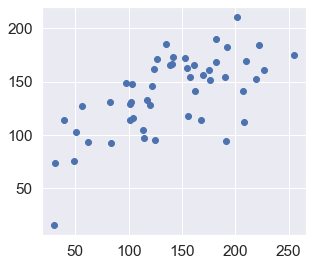

In [520]:
plt.scatter(y, deathModel.fittedvalues)
plt.gca().set_aspect('equal', adjustable='box')

In [498]:
demographicPredictions = pd.DataFrame()
demographicPredictions["Positivity Rate"] = positivityModel.fittedvalues
demographicPredictions["Deaths / Population"] = deathModel.fittedvalues/100000

print(demographicPredictions)
demographicPredictions.to_csv("data/results/demographicPredictions.csv")

    Positivity Rate  Deaths / Population
0          0.131342         1.546062e-06
1          0.066475         1.137148e-06
2          0.111910         1.414363e-06
3          0.149364         1.514667e-06
4          0.070300         1.284517e-06
5          0.081468         1.291911e-06
6          0.035856         1.692311e-06
7          0.070367         1.850668e-06
8          0.101423         1.659700e-06
9          0.128753         1.719794e-06
10         0.034152         1.565863e-07
11         0.136694         1.143184e-06
12         0.080791         1.608905e-06
13         0.128801         1.681488e-06
14         0.136078         1.141502e-06
15         0.136491         1.177524e-06
16         0.127013         1.486850e-06
17         0.145686         2.102103e-06
18         0.047401         7.607294e-07
19         0.057708         1.716103e-06
20         0.034381         1.605558e-06
21         0.082969         1.414362e-06
22         0.089053         1.047190e-06
23         0.150